## Forest Fire -  Model of self-organized criticality

In [30]:
import random
import numpy as np
import pprint
import copy
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [31]:
def create_grid(size = 10, cell=0):
    grid = []
    for x in range(0,size):
        grid.append([cell]*size)
    return grid

def chance(p=0.8):
    "returns 1 following given probability"
    number = random.random()
    if number <= p:
        return 1 
    return 0

def is_tree(x,y,grid):
    #out of range
    if x < 0 or y < 0:
        return 0
    try:
        if grid[x][y] == 1:
            return 1
    #out of range 2
    except IndexError:
        return 0    
    return 0

def light_up_coordinates(x,y, grid):
    "helper function"
    copied_list = copy.deepcopy(grid)
    copied_list[x][y] = '$'
    for x in copied_list:
        print(x)
        
def make_turn(x,y, grid, prob=0.8, population=0):
    if is_tree(x,y, grid):
        if chance(p=1-prob): 
            # tree burns
            burned = burn_trees_faster(x,y, grid)
            population -= burned
    else:
        if chance(p=prob):
            # tree grows
            population += 1
            grid[x][y] = 1
    return population

def return_all_neighbors(x,y, grid):
    trees_to_check = []
    #all neighbors
    for n_x,n_y in [(x-1,y+1),(x, y+1),(x+1,y+1),(x+1, y),(x+1,y-1),(x,y-1),(x-1,y-1),(x-1,y)]:
        if is_tree(n_x,n_y, grid):
            trees_to_check.append((n_x,n_y))
    return trees_to_check

def burn_trees(root_x, root_y, grid):
    "burns tree and all neighbors"
    trees = [(root_x,root_y)]
    #obtaining the patch of neighboring trees
    for x,y in trees:
        new_trees = []
        new_trees += return_all_neighbors(x,y, grid)
        # this check is inefficient as it's almost tree_neighbors^2 complexity. The set implementation below is much faster
        for n_x, n_y in new_trees:
            if (n_x,n_y) not in trees:
                trees.append((n_x,n_y))
    #burning them all
    for x,y in trees:
        grid[x][y] = 0
    return len(trees)

def burn_trees_faster(root_x, root_y, grid):
    "burns tree and all neighbors"
    trees = set()
    trees.add((root_x,root_y))
    trees_burned = 0
    while True:
        if trees == set():
            return trees_burned
        trees_burned += 1
        tree = trees.pop()
        #burning the trees
        grid[tree[0]][tree[1]] = 0
        neighboring_trees = return_all_neighbors(tree[0],tree[1], grid)
        for neighbor in neighboring_trees:
            trees.add(neighbor)
            
def simulate_forest(grid_size=10, t=200, trials=100, prob=0.8):
    """simulates forest over t time-periods, with probability being that of tree-growth each t, 
    and 1-prob that of lightning each t. 
    The resulting forest population is averaged over the number of trials
    """
    populations = list()
    for run in range(trials):
        grid = create_grid(grid_size)
        population = 0
        population_development = list()
        for x in range(t):
            population_development.append(population)
            population = make_turn(random.randint(0,grid_size-1),random.randint(0,grid_size-1), grid, population=population, prob=prob)
        populations.append(population_development)
    # averaging over number of trials
    np_populations = np.array(populations)
    average = np_populations.mean(axis=0)
    std = np_populations.std(axis=0)
    return prob, average, std

def plot_forest(simulation):
    prob, y, error = simulation
#     print(np.min(error))
#     print(np.mean(error))
#     print(np.max(error))
    x = range(len(y))
    plt.fill_between(range(len(y)), y-error/2, y+error/2, alpha=0.5)
    plt.plot(y,'-', label='probability of lightning: {}'.format(1-prob))
    plt.xlabel('time')
    plt.ylabel('size of forest')

## the model
The forest fire model assumes a two-dimensional grid on which trees can grow. Trees can also get hit by random lightning strikes which results in the tree and all connected neighbors burning. 
In a *sparse* forest any fires will be small. With increasing density a fire started can spread across much of the grid.

**formal definition:** 
The model assumes an empty *N by N* grid. Each period a random site on the grid is chosen. If empty, with probability g the site grows a tree. If the site contains a tree, with probability (1-g) lightning hits the site. If the site contains a tree, the tree catches fire, and the fire spreads to all connected sites with trees. Source: The Model Thinker, a fantastic book by Scott Page. 

for example this is a forest on a `100*100` grid with probability of lightning = `0.2` and probability of tree-growth = `0.8`. 

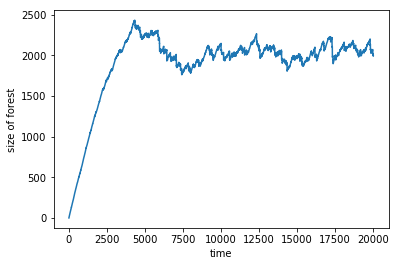

In [32]:
plot_forest(simulate_forest(grid_size=100, t=20000, trials=1, prob=0.80))

We can see the forest self-organizing to a **critical state** of supporting around 2000 trees (+- 500). 

This critical state can be seen even better if you take the average of say 30 runs:

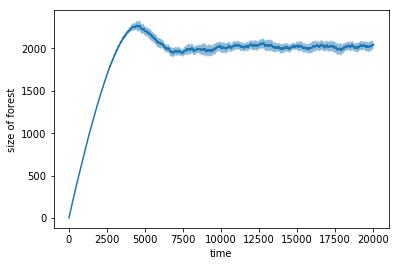

In [33]:
plot_forest(simulate_forest(grid_size=100, t=20000, trials=30, prob=0.80))

But why do we see this initial "hump" of the forest being able to shoot significantly above our level of criticality?

It occurs because of our artificial assumption that trees grow spread sparsely across the grid but burn in patches.
As said, growing a thin forest keeps fires small and with that increased resistance it is able to temporarily support a larger population of trees. 
As the forest densifies and trees burn in *patches* however, the likelihood of any one lightning hit producing a large-scale fire has increased to the point that the permanent stable critical state lowers down again. 

**Note: the assumption of trees growing so sparsely is of course an artificial one so in the real world there probably wouldn't be any such hump*

Interestingly, on a smaller grid we see no such hump

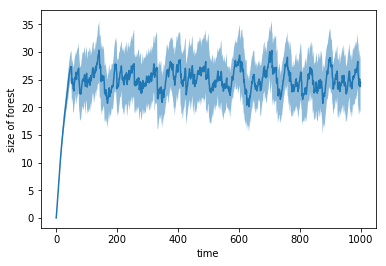

In [36]:
plot_forest(simulate_forest(grid_size=10, t=1000, trials=30, prob=0.80))

**why?**

because the grid is too small to support separate individual clusters of forest so each turn almost the whole forest burns down and grows back again:

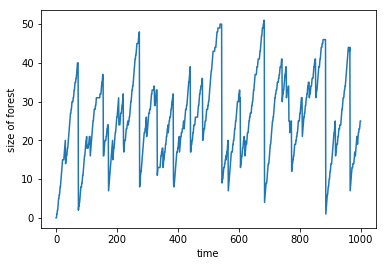

In [37]:
plot_forest(simulate_forest(grid_size=10, t=1000, trials=1, prob=0.80))

## Power Law distribution of fires
What's interesting about this is using this model to study self-organized criticality, an example of naturally occuring power-law distribution.
Near the critical state (for values close to 1, otherwise no such critical state forms as the forest lacks density), the sizes of the patches of forest, and therefore the size of potential fires, follow a power-law distribution. As explained above, the forest naturally tends towards this level. 

Notice that the **critical state is not reached by an adjustment of a parameter, i.e. trees don't learn to adjust how far away from a neighboring tree they should grow.**
Instead, the two necessary conditions for self-organized criticality are the gradual increase in pressure (tree-growth) and sudden decrease in bursts (fires), the size of which follows, as said, a power-law distribution quite nicely. 

In [ ]:
plot_forest(simulate_forest(grid_size=10, t=1000, trials=1, prob=0.80))

In [ ]:
fig= plt.figure(figsize=(15,7))
plot_forest(simulate_forest(grid_size=10, t=20000, trials=1, prob=0.999))
plot_forest(simulate_forest(grid_size=10, t=20000, trials=1, prob=0.95))
plot_forest(simulate_forest(grid_size=10, t=20000, trials=1, prob=0.80))
plt.legend()
plt.show()

## Appendix A: Tuning my burn function

In [29]:
grid = create_grid(100, cell=1)
start = time.time()
burn_trees(50,50, grid)
end = time.time()
print('function burn_trees: ',end - start)

grid = create_grid(100, cell=1)
start = time.time()
burn_trees_faster(50,50, grid)
end = time.time()
print('function burn_trees_faster: ',end - start)

function burn_trees:  10.654033899307251
function burn_trees_faster:  0.04680275917053223


## Appendix B: Chance of lightning

to keep a record of the intution:
the two balancing forces that **matter** are:
1. gradual tree growth (albeit slowing, but that doesn't matter)
2. sudden bursts of large swathes of forest

Below I looked at the chance of lightning increasing with a growing forest which follows a linear distribution. It tends toward 20%, which is the chance of lightning in a 100% dense forest. 
Initially, I thought the higher chance of lightning might be co-responsible for reaching a state of criticality. However, whilst this growing linear trend *influences* the exact point at which the criticality lies (it's mathematically acts as an *offset*, it's not at all a necessary condition for enabling such a level of criticality. Instead, the distribution of forest patches approximately following a power-law which allows for sudden huge losses of trees. 
If we wouldn't have these patches of trees forming and as a fixed rule have any lightning strike burn 2 trees

In [117]:
lst = [0]
n = 0
max_n = 10000
for t in range(200000):
    if chance(p=1-(n/max_n)):
        n += 1
    else:
        probability_of_fire = 1 if (n/max_n) > 1 else (n/max_n) * 0.2
        if chance(p=probability_of_fire):
            n -= 20
        # probability_of_fire = probability that a tree is selected * probability that its hits by lightning
    lst.append(n)

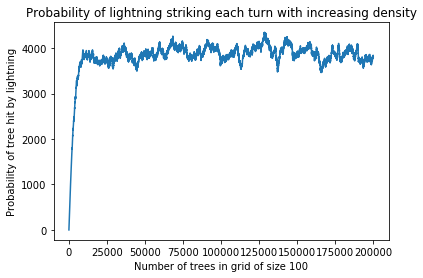

In [118]:
plt.plot(lst)
plt.title('Probability of lightning striking each turn with increasing density')
plt.ylabel('Probability of tree hit by lightning')
plt.xlabel('Number of trees in grid of size 100')
plt.show()

In [39]:
0/100

0.0

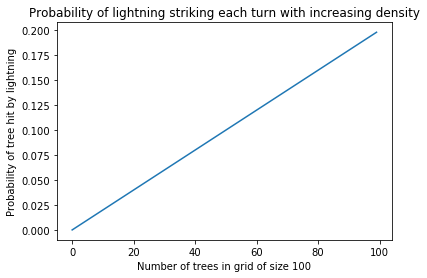

In [38]:
lst = list()
for n in range(100):
    # probability_of_fire = probability that a tree is selected * probability that its hits by lightning
    probability_of_fire = (n/100) * 0.2
    lst.append(probability_of_fire)

plt.plot(lst)
plt.title('Probability of lightning striking each turn with increasing density')
plt.ylabel('Probability of tree hit by lightning')
plt.xlabel('Number of trees in grid of size 100')
plt.show()